# Git Repository Bringup

In [70]:
!git version

git version 2.34.1
time: 107 ms (started: 2023-09-25 21:40:40 +00:00)


In [71]:
!git clone https://github.com/ramwtz/data-science-project.git

fatal: destination path 'data-science-project' already exists and is not an empty directory.
time: 106 ms (started: 2023-09-25 21:40:41 +00:00)


In [72]:
!ls

data-science-project  drive  sample_data
time: 108 ms (started: 2023-09-25 21:40:41 +00:00)


In [73]:
%cd data-science-project/

/content/data-science-project
time: 2.18 ms (started: 2023-09-25 21:40:41 +00:00)


In [74]:
!pwd

/content/data-science-project
time: 106 ms (started: 2023-09-25 21:40:41 +00:00)


In [75]:
!git switch dev/ram

Already on 'dev/ram'
Your branch is up to date with 'origin/dev/ram'.
time: 106 ms (started: 2023-09-25 21:40:41 +00:00)


In [76]:
%cd ..

/content
time: 4.57 ms (started: 2023-09-25 21:40:41 +00:00)


# Basic Bringup for Remote Envrionment

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2 s (started: 2023-09-25 21:40:43 +00:00)


In [78]:
# Necessary packages for this nb
!pip install --quiet -r '/content/data-science-project/dependencies.txt'

time: 7.76 s (started: 2023-09-25 21:40:45 +00:00)


# Initialize Env

In [79]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa as lbrs
import IPython
import IPython.display as ipd
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn import metrics
from scipy import fft

# Configs
%load_ext autotime
tqdm.pandas()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.34 ms (started: 2023-09-25 21:40:55 +00:00)


In [80]:
gen_data_dir = os.path.join('drive', 'MyDrive', 'project', 'data')
calls_dir = os.path.join(gen_data_dir, 'calls')
new_data_dir = os.path.join(gen_data_dir, 'new')

#
metadata_path = os.path.join(calls_dir, '911_first6sec', '911_metadata_6sec.csv')

time: 909 µs (started: 2023-09-25 21:40:55 +00:00)


In [81]:
def get_path_from_filename(audio_file_name):
    type_dir, file_name = audio_file_name.split('/')
    return os.path.join(calls_dir, type_dir, file_name)

time: 687 µs (started: 2023-09-25 21:40:55 +00:00)


# EDA

## Intro

In [82]:
# load metadata from csv to a pandas dataframe
metadata_df = pd.read_csv(metadata_path)

time: 20 ms (started: 2023-09-25 21:40:57 +00:00)


In [83]:
metadata_df.count()

id                 710
event_id           710
link               710
title              710
date               689
state              702
deaths             709
potential_death    709
false_alarm        709
description        701
deaths_binary      710
break              710
filename           710
dtype: int64

time: 10.5 ms (started: 2023-09-25 21:40:57 +00:00)


In [84]:
# TODO (ram): need to find the duplicates
metadata_df.drop_duplicates(subset=['filename'], inplace=True)
metadata_df.reset_index(drop=True, inplace=True)
metadata_df.count()

id                 707
event_id           707
link               707
title              707
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      707
break              707
filename           707
dtype: int64

time: 13.6 ms (started: 2023-09-25 21:40:57 +00:00)


In [85]:
metadata_df[metadata_df['deaths'].isnull()]

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
39,39,54,https://web.archive.org/web/20150417085342/htt...,Boat rescue #1 – Minn.,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,911_first6sec/call_54_0.wav


time: 20.8 ms (started: 2023-09-25 21:40:57 +00:00)


In [86]:
# TODO (Ram): maybe we can tag this ourselves
metadata_df = metadata_df[metadata_df['deaths'].notna()]
metadata_df.reset_index(drop=True, inplace=True)
metadata_df.count()

id                 706
event_id           706
link               706
title              706
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      706
break              706
filename           706
dtype: int64

time: 7.33 ms (started: 2023-09-25 21:40:57 +00:00)


## Audio Analysis Overview
---







  

### 1. Frequency:
  - Describes the rate of oscillation (vibration).
  - Denoted in Hz (1/sec).
  - Is understood by the human ear as 'pitch'.
  - The human ear is considered to be able to hear within the range of 20 Hz to 20,000 Hz.
  
  <img src="https://uploads-cdn.omnicalculator.com/images/britannica-wave-frequency.jpg" width="500"/>

### 2. Intensity (Power):
  - Proportional to the **amplitude** of the audio wave [[1]](http://theory.physics.ubc.ca/341-current/dB.pdf).
  - Denoted in dB, with a pre-defined base 0dB, as it is a comapritive logarithmic scale.
  - Is understood by the human ear as 'loudness'
  - dB = 20 * log10(amplitude) [[2]](https://blog.demofox.org/2015/04/14/decibels-db-and-amplitude/)
  
  <img src="https://theproaudiofiles.com/wp-content/uploads/2018/06/decibel-chart.png" width="500"/>

### 3. The relationship between Frequency and Intensity:
  
  <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124722804500162-f13-15-9780124722804.gif" width="500"/>

### 4. Sample Rate:
  - The rate at which we sample discrete audio signals, the standard of audio sampling is 44.1 kHz ([for historic reasons](https://www.cardinalpeak.com/blog/why-do-cds-use-a-sampling-rate-of-44-1-khz)), that is 44,100 samples per second.

  <img src="https://cdn.shopify.com/s/files/1/0970/0050/files/Sample_Rate.png?1870870584085320152" width="600"/>

### 5. Time Domain vs Frequency Domain:
  - In the Time Domain we observe the audio signal as a function of time, see example image in (3).
  - In the Frequency Domain we observe the audio signal as a function of frequency, with each frequency's contribution to the signal being measured.

## Analysis in The Time Domain
---

Now lets look over a sample audio file and see how we can observe these features in the time domain:

First we can sample an audio file to listen too, so we can compare the data to actual human comprehendible sound:

In [87]:
# sample a single audio file
sample = metadata_df.sample(1)
sample_filename = sample['filename'].iat[0]
sample_path = get_path_from_filename(sample_filename)

# Create playable audio
IPython.display.display(ipd.Audio(sample_path))

time: 292 ms (started: 2023-09-25 21:40:57 +00:00)


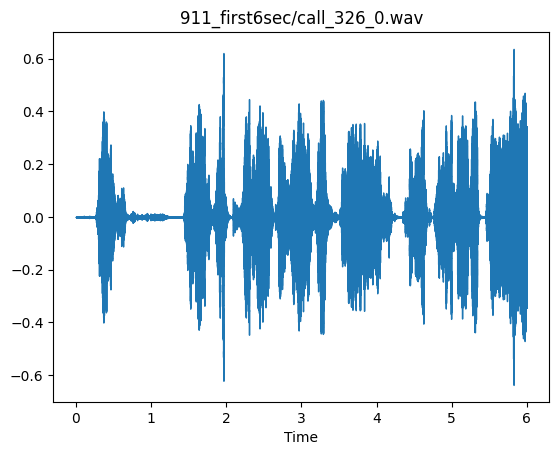

time: 551 ms (started: 2023-09-25 21:40:58 +00:00)


In [88]:
# Get digital signal data
sample_data, sample_rate = lbrs.load(sample_path)

# Plot waveform
lbrs.display.waveshow(sample_data, sr=sample_rate)
plt.title(sample_filename)
plt.show()

We can see the values of the amplitude in the y-axis and the passage of time in the x-axis, lets zoom in:

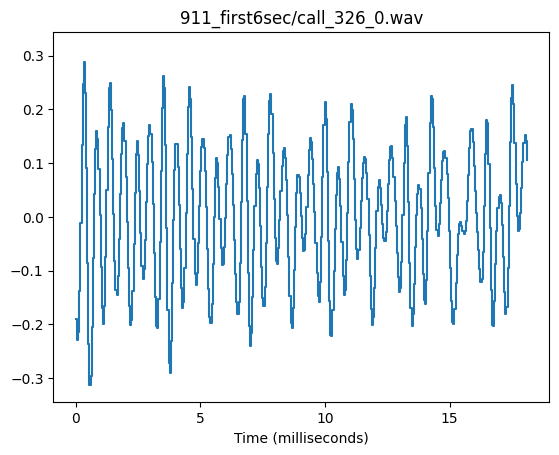

time: 318 ms (started: 2023-09-25 21:40:58 +00:00)


In [89]:
# fetch a smaller segment in the middle of the signal
mid_point = len(sample_data) // 2
zoom_in_data = sample_data[mid_point - 200 : mid_point + 200]

lbrs.display.waveshow(
    zoom_in_data, sr=sample_rate, axis='ms', label=sample_filename)
plt.title(sample_filename)
plt.show()

This is just a fraction of the sound, and we can much more easily see that this is wave made of samples by the jaged edges.


## Analysis in the Frequency Domain
---
We will need to visualize our samples in the frequency domain, these "new" samples are of the kind that will be used for training our model.

### Creating a magnitude spectrum - Intro
To understand the following method, we need to go over a few things:

#### 1. Applying FFT
  Applying FFT to the audio data will return an array of complex number, which can also be interpreted as vectors, with the norm of each vector (absolute value of a complex number) being the *power* of the frequency, and the direction of the vector (angle) repesnting the *phase* of the frequency.

  For example:

  <img src="https://robocrop.realpython.net/?url=https%3A//files.realpython.com/media/pianofreqblue.ff266a14503f.png&w=875&sig=15d13cbf8bbfce339bedb40297c8ac161db867bc" width="500"/>

  Here we can see that the **highest** note was played the **weakest**.


#### 2. Frequency Bins:
  When Applying an FFT on a continuous wave,because between any two discrete points are infinite points in the continuous field, we essnently check the "average" power of some small sub segment of the wave, which we call a frequency bin, in most cases our bins will be very small.

  The most intuitive way to think of this is as if we're creating a Histogram

### Frequency Magnitude Specrtum
now let us use this information to create a magnitude spectrum:

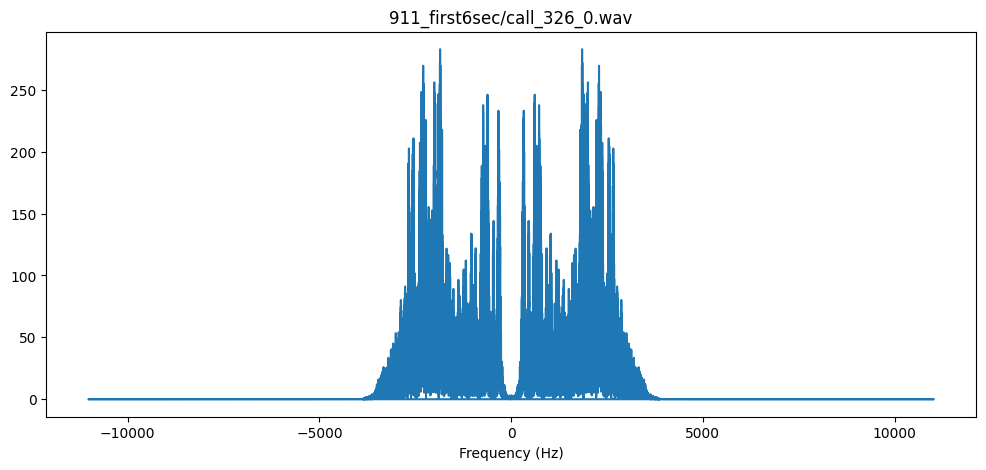

time: 997 ms (started: 2023-09-25 21:40:58 +00:00)


In [90]:
# get frequency bins and magnitude
ft = fft.fft(sample_data)
mag_spec = np.abs(ft)
frequency_bins = fft.fftfreq(sample_rate*6, 1/sample_rate)

# plot
plt.figure(figsize=(12,5))
plt.plot(frequency_bins, mag_spec)
plt.xlabel('Frequency (Hz)')
plt.title(sample_filename)
plt.show()

Because we've used real numbers as the input for the FFT we've received this symmetry, we want to remove this as the left half is superfluous, we will use scipy's rfft (real fft) for this:

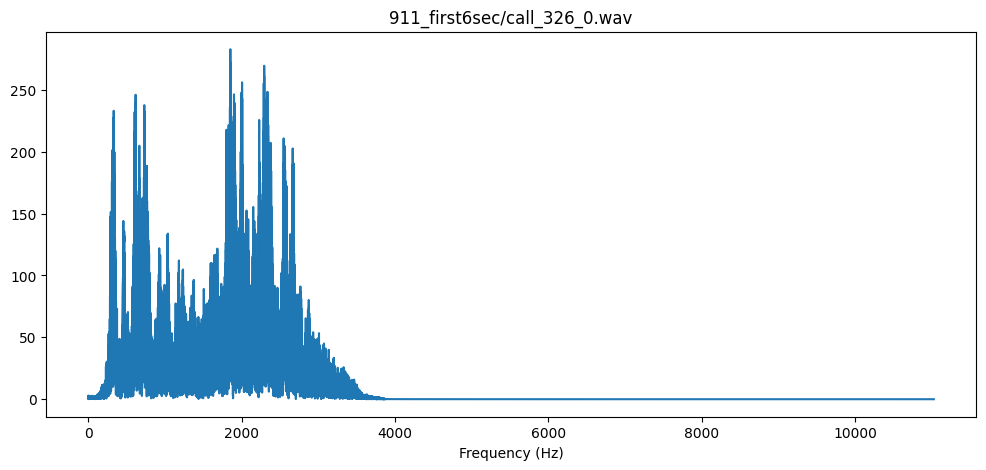

time: 789 ms (started: 2023-09-25 21:41:00 +00:00)


In [91]:
# switch to real fft
ft = fft.rfft(sample_data)
mag_spec = np.abs(ft)
frequency_bins = fft.rfftfreq(sample_rate*6, 1/sample_rate)

# stays the same
plt.figure(figsize=(12,5))
plt.plot(frequency_bins, mag_spec)
plt.xlabel('Frequency (Hz)')
plt.title(sample_filename)
plt.show()

## Analysis in the Frequency Domain and Time Domain
---
We can analyze in both the frequency and time domains using a "Spectrogram", which we will cover in this section

### Short-time Fourier Transform:
before we plot the spectrogram we need to familiarize ourselves with a short-term fourier transform, in this transformation we separate the signal into 'chunks' of equal lengths, and calculate the DFT for each segment, we then get a 2-dimensional array we can plot 'over-time' in the spectrogram.

The windows are overlapping.

There are 2 important terms we need to know:
1. Frame Size (Number of FFTs):
The length of each chunk window (including zero padding)
2. Hop Length:
The number of audio samples per STFT column

### Reading the Spectrogram
The graph is read in the following way:
- The x-axis represents the passage of time, similarly to a wave plot.
- The y-axis represents the frequencies, like the x-axis of the magnitude spectrum
- The hue of the graph represents the intensity (power) of the frequency, with colder/lighter hues representing lower values, and darker/hotter hues representing higher values.

### Spectrogram for sample
let us compute and plot the stft:

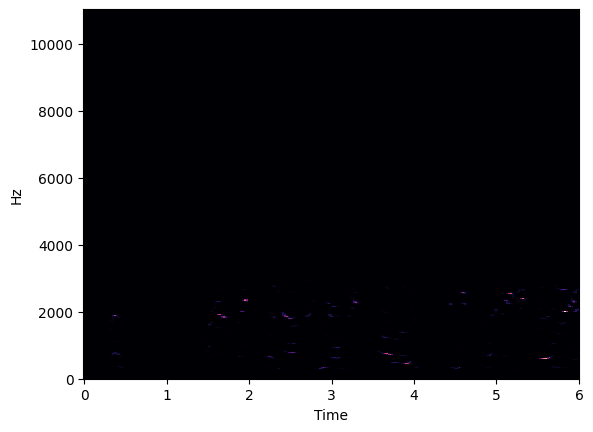

time: 1.73 s (started: 2023-09-25 21:41:00 +00:00)


In [92]:
# standard sizes
frame_size = 2048
hop_size = 512

# Calculate the power of each chunk
stft_data = lbrs.stft(sample_data, n_fft=frame_size, hop_length=hop_size)
stft_data = np.abs(stft_data) ** 2

# display over linear graph
lbrs.display.specshow(
    stft_data, hop_length=hop_size, sr=sample_rate, x_axis='time', y_axis='linear')
plt.show()

We can barely see anything, except minor heat maps in the lower part, this is because the plotting is linear, and most (higher) sounds are not as interesting or audible by humans, we can move to a lograithmic plot to improve our visuals:

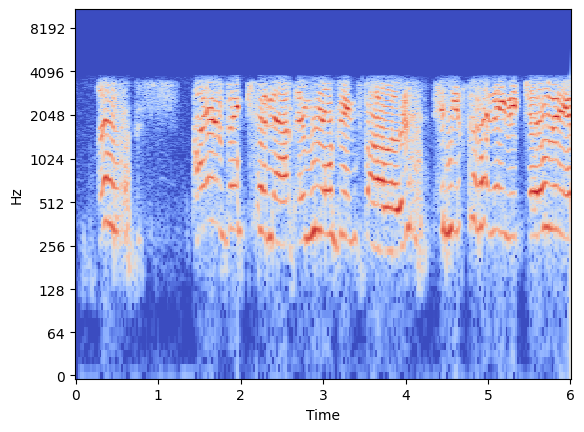

time: 1.81 s (started: 2023-09-25 21:41:02 +00:00)


In [93]:
# standard sizes
frame_size = 2048
hop_size = 512

# use dB which as stated above are log-scaled
stft_data = lbrs.stft(sample_data, n_fft=frame_size, hop_length=hop_size)
stft_data = np.abs(stft_data)
stft_data_log = lbrs.amplitude_to_db(stft_data)


# switch y-axis to log
lbrs.display.specshow(
    stft_data_log, hop_length=hop_size, sr=sample_rate,
    x_axis='time', y_axis='log')
plt.show()

Much more human-readable.

## Sampling the Dataset

In [94]:
def get_audio_data(audio_file_name):
    audio_file_path = get_path_from_filename(audio_file_name)
    data, sample_rate = lbrs.load(audio_file_path)
    return data, sample_rate

time: 4.57 ms (started: 2023-09-25 21:41:04 +00:00)


In [95]:
def magnitude_spectrum_plot(data, sample_rate, ax):
  ft = np.fft.rfft(data)
  mag_spec = np.abs(ft)
  frequency_bins = fft.rfftfreq(sample_rate*6, 1/sample_rate)

  ax.plot(frequency_bins, mag_spec)
  ax.set_xlabel('Frequency (Hz)')
  ticks = ax.get_xticks()
  ticks = ticks.astype(np.int32)
  ax.set_xticks(ticks)

time: 1.01 ms (started: 2023-09-25 21:41:04 +00:00)


In [99]:
def spectrogram_plot(data, sample_rate, ax):
  stft_data = lbrs.stft(data)

  # use dB which as stated above are log-scaled
  stft_data = np.abs(stft_data)
  stft_data_log = lbrs.amplitude_to_db(stft_data)

  # switch y-axis to log
  return lbrs.display.specshow(
      stft_data_log, sr=sample_rate,
      x_axis='time', y_axis='log', ax=ax)

time: 1.02 ms (started: 2023-09-25 21:43:52 +00:00)


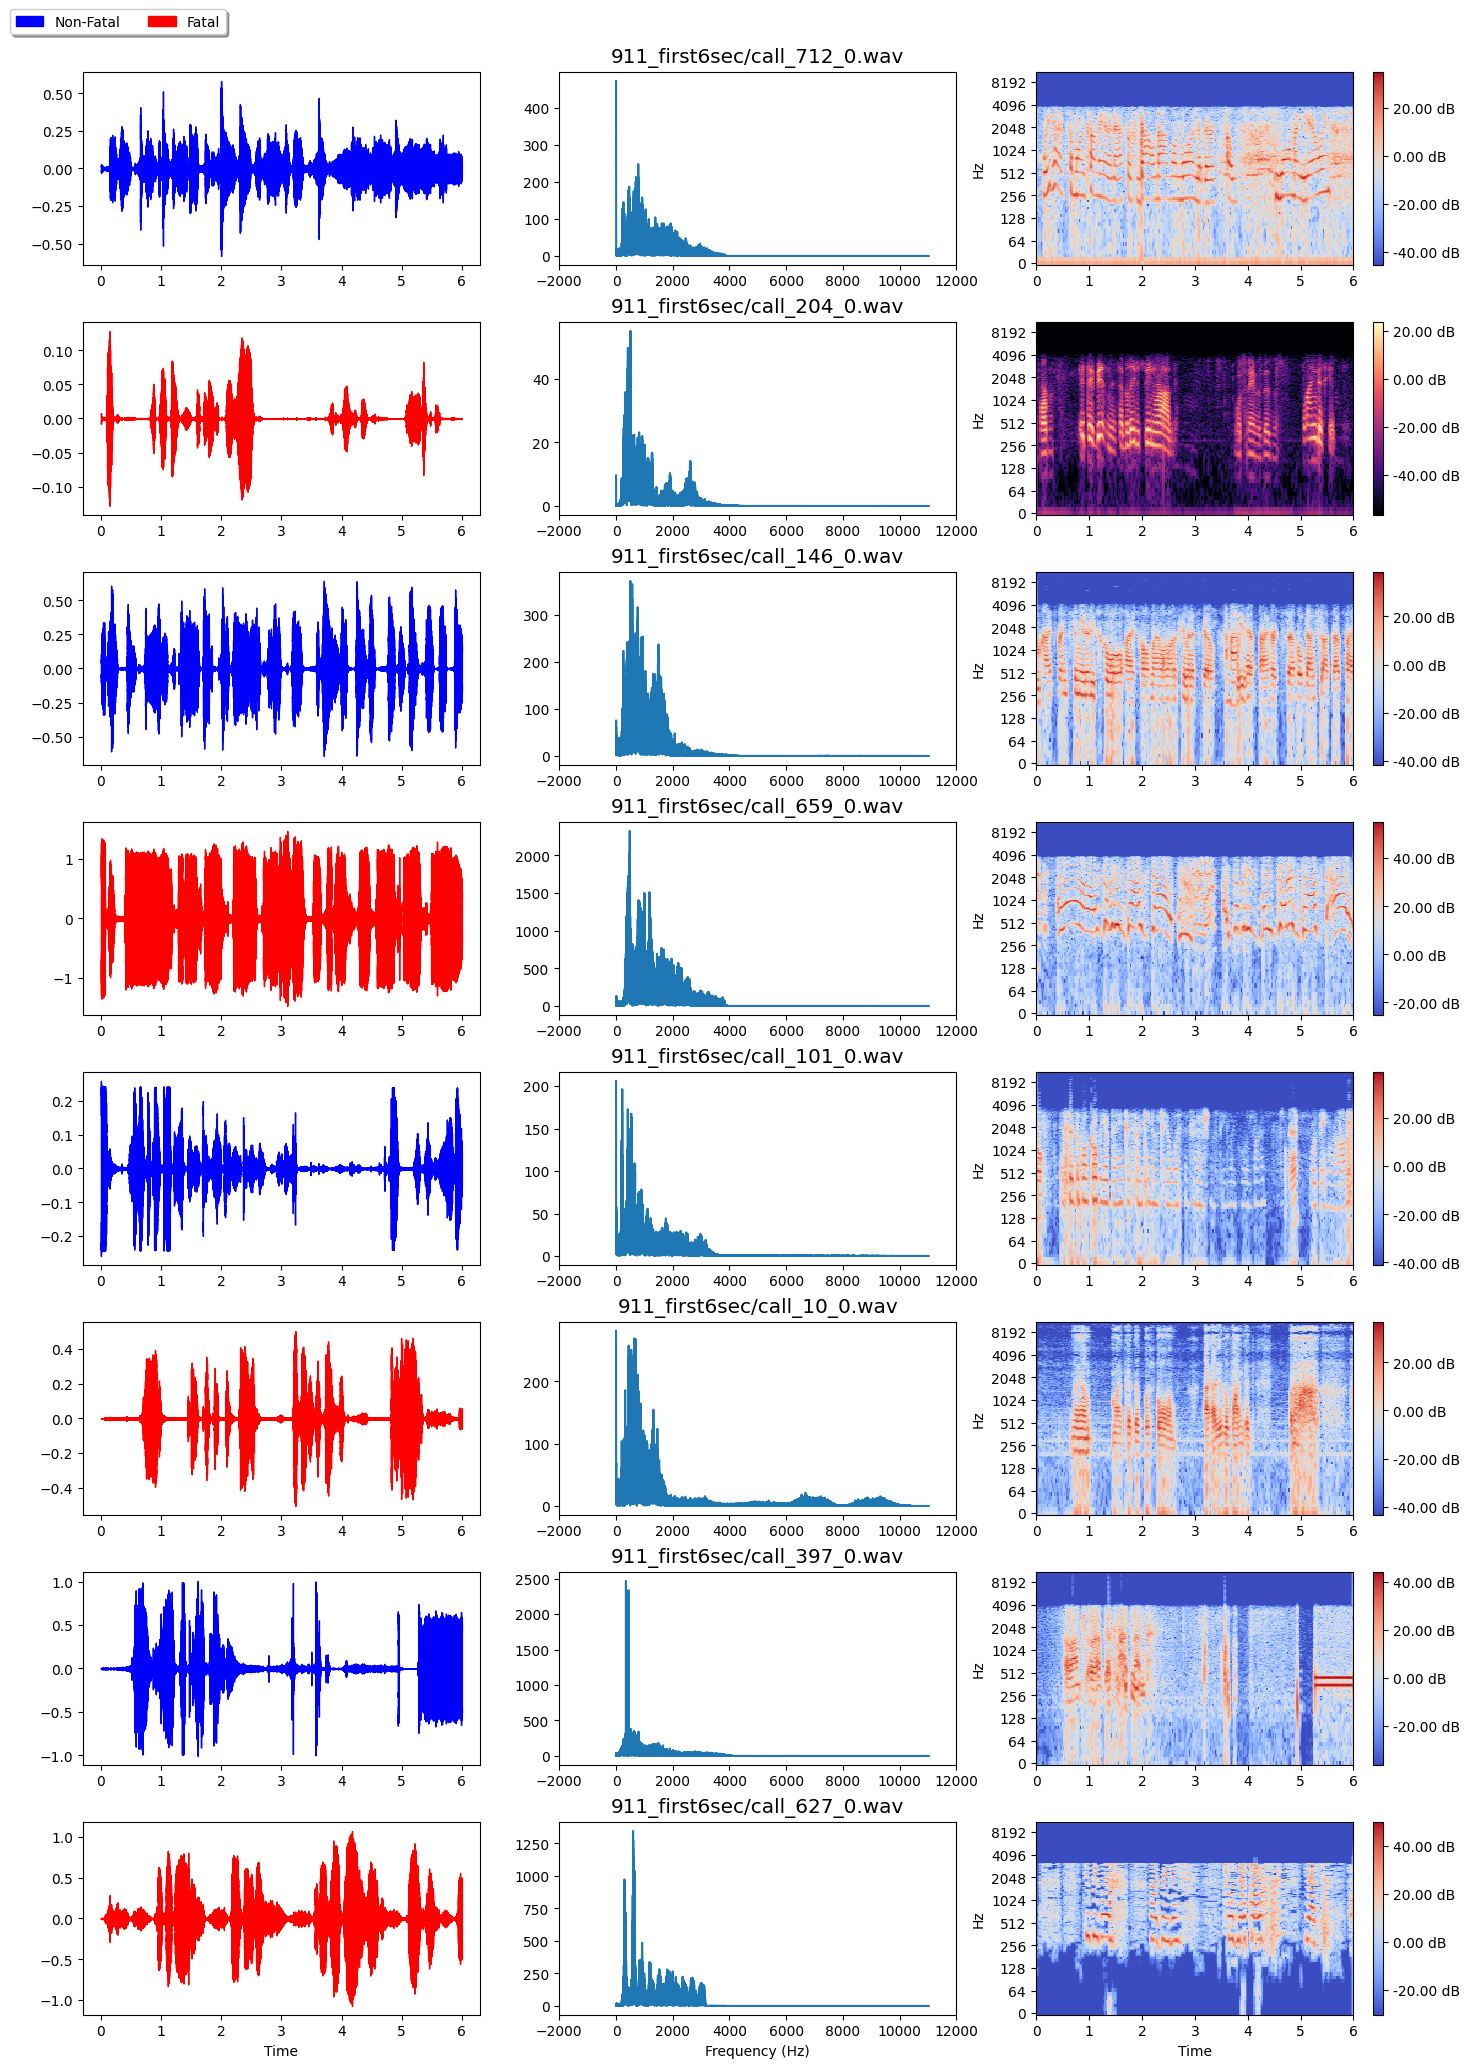

time: 31.5 s (started: 2023-09-25 21:43:54 +00:00)


In [100]:
# create base figure
fig = plt.figure(figsize=(15, 20))
subfigs = fig.subfigures(nrows=8, ncols=1)

# add legend
red_patch = mpatches.Patch(color='red', label='Fatal')
blue_patch = mpatches.Patch(color='blue', label='Non-Fatal')
fig.legend(
    handles=[blue_patch, red_patch], bbox_to_anchor=(0.1, 1.02),
    ncol=2, fancybox=True, shadow=True)

# populate subfigures
for i, subfig in enumerate(subfigs):

  # create subplots in subfigure
  sub_axs = subfig.subplots(nrows=1, ncols=3, squeeze=True)
  subfig.subplots_adjust(left=0)

  # choose between fatal and non-fatal
  cls = i % 2
  color = 'r' if cls else 'b'

  # get audio data
  sample = metadata_df[metadata_df['deaths_binary'] == cls].sample(1)
  sample_filename = sample['filename'].iat[0]
  y, sr = get_audio_data(sample_filename)

  # add title to subfigure
  subfig.suptitle(sample_filename, x=0.45, fontsize='x-large')

  # add wave plot
  lbrs.display.waveshow(y=y, sr=sr, ax=sub_axs[0], color=color)

  # add magnitude spectrum
  magnitude_spectrum_plot(y, sr, ax=sub_axs[1])

  # add spectrogram
  img = spectrogram_plot(y, sr, ax=sub_axs[2])
  subfig.colorbar(img, ax=sub_axs[2], format=f'%0.2f dB')

plt.show()